Copying over much of the material from SignalToNoise_azimuthalaveraging.  Going to invert the signal-to-noise equation to find the dependance of SB on radius for a specific exposure time and specific signal-to-noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u
%matplotlib inline

In [2]:
def Dragonfly(CMOS=True,filtwidth=3.0,verbose=True,R=None,old=False):
    area_lens = np.pi*(14.3/2)**2 * 48. * u.cm**2               # 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                              # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the CCD

    tau_l = 0.85  # transmittance of the Dragonfly lens
    tau_f = 1.    # transmittance of the Halpha filter -- assumed for now
    if CMOS:
        print "VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)"
        QE = 0.70                                           # quantum efficiency of the CMOS detector
    else:
        print "VERBOSE: Using old cameras... (QE = 0.48, R = 10.)"
        QE = 0.48                                           # quantum efficiency of the CCD

    # The following are per pixel
    D = 0.04 *u.photon/u.second                             # dark current (electrons / s) -- PER PIXEL??
    R_squared = 10.**2 * u.photon                           # read noise (electrons)
    
    #filtdict = {1.0:0.560633,3.0:1.473626,'SloanG':60.0}
    if old:
        B = 0.52135 *u.photon/u.second/u.nm/u.arcsec**2/u.m**2  # sky background at 565.6 nm 
    else:
        B = 1.473626 *u.photon/u.second/u.arcsec**2/u.m**2  # sky background at 565.6 nm in 3 nm filter
    #B = filtdict[filtwidth]
    
    if R is None:
        if CMOS:
            R = 2.                                          # read noise of CMOS (electrons)
        else:
            R = 10.                                         # read noise of CCD (electrons)
    
    R_squared = R**2 * u.photon
    
    if verbose:
        print ""
        print "[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared]"
        print [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared]
        print ""
    
    return [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared]



In [5]:
old=False

[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared] = Dragonfly(CMOS=True,old=old)

print([area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared])
wavelen = 656.3e-9 * u.m

### SB of extended halos
SB_ph_upper = 2245.38 * u.photon / (u.cm**2 * u.rad**2 * u.second) # threshold from Steidel et al 2011 plus long translations
SB_ph_lower = 559.60 * u.photon / (u.cm**2 * u.rad**2 * u.second)  # from van de Voort & Schaye 2013 (high mass out to 100 kpc)
SB_ph_evenlower = 280. * u.photon / (u.cm**2 * u.rad**2 * u.second)  # from van de Voort & Schaye 2013 (medium mass out to 50 kpc)
SB_ph_abslowest = 140. * u.photon / (u.cm**2 * u.rad**2 * u.second)  # from van de Voort & Schaye 2013 (medium mass out to 80 kpc)

SB_ph_0 = 1. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_1 = 10. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_2 = 100. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_3 = 1000. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_4 = 10000. * u.photon / (u.cm**2 * u.rad**2 * u.second) 

SB_ph_5 = 250. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_6 = 500. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_7 = 750. * u.photon / (u.cm**2 * u.rad**2 * u.second) 

print('Surface brightness: '+str(SB_ph_evenlower))

VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)

[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared]
[<Quantity 7709.091380790922 cm2>, <Quantity 1.8427438923353984e-10 rad2>, 2.8, 0.85, 1.0, 0.7, <Quantity 1.473626 ph / (arcsec2 m2 s)>, <Quantity 0.04 ph / s>, <Quantity 4.0 ph>]

[<Quantity 7709.091380790922 cm2>, <Quantity 1.8427438923353984e-10 rad2>, 2.8, 0.85, 1.0, 0.7, <Quantity 1.473626 ph / (arcsec2 m2 s)>, <Quantity 0.04 ph / s>, <Quantity 4.0 ph>]
Surface brightness: 280.0 ph / (cm2 rad2 s)


In [ ]:
# pick numpixels:
numpixel = 3700.

# pick how long to calculate SNR over
time = np.arange(1,60.*60.*1000000.,1000)* u.second
time = np.arange(1,60.*60.*280.)* u.second
limit = time[-1]/u.second

fig,(ax1) = plt.subplots(1,1,figsize=(12, 6))

for SB_ph in [SB_ph_0, SB_ph_1, SB_ph_2, SB_ph_3, SB_ph_4,SB_ph_5,SB_ph_6,SB_ph_7]:
#for SB_ph in [SB_ph_upper, SB_ph_lower, SB_ph_evenlower, SB_ph_abslowest]:
    ## Signal
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    ## Noise
    if old:
        B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    else:
        B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    # Note that the signal is about an eighth the strength of the background sky signal: IS THIS TRUE HERE?
    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    ax1.plot(time/3600., signal/sigma, label=str(SB_ph))#,label= 'num pixels '+str(round(numpixel)))

ax1.plot([0,limit/3600.],[5,5],'k--')   
plt.title(r'H$\alpha$ Halo Emission')
ax1.legend(title='Surface Brightness:')
ax1.set_xlim(0,limit/3600.)
ax1.set_ylim(0,10)
ax1.set_xlabel('time (hours)')
ax1.set_ylabel('SNR')

ax1.plot([4.,4.],[0,10],'k--')  # ~4 hour ~250min
ax1.plot([70,70],[0,10],'k--')  # ~70 hour ~4200min




$signal = ( SB \times QE \times \tau_l \times \tau_f \times LensArea) \times time \times numpix = S \times time \times numpix $

$background = B \times QE \times \tau_l \times \tau_f \times LensArea \times AngPixelSize $

$noise = \sqrt(signal + background \times time \times numpix + D \times time \times numpix + R^2 \times numpix)$

$S/N = signal / noise$

### Starting from surface brightness and looping around.

In [9]:
# pick a surface brightness
SB_tousehere = SB_ph_2

# pick numpixels:
numpixel = 800.*3.

# pick how long to calculate SNR over
time = 100. * 60.* 60.* u.second
print 'The original surface brightness is %s'% SB_ph_2

# calculate the signal
S = SB_tousehere * QE * tau_l * tau_f * area_lens * ang_size_pixel
signal = S*time*numpixel

print 'The signal produced by this surface brightness is %s'% signal

# calculate the background
B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
x = B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel

sigma = np.sqrt(signal + x)
signaltonoise = signal/sigma

print 'The resulting signal-to-noise ratio is %s'%signaltonoise

# invert the equation to get the original value back
signal_back = (signaltonoise**2 + np.sqrt(signaltonoise**4 + 4*signaltonoise**2*x))/2.

print 'Calculating the signal from the signal-to-noise ratio and noise gives %s' %signal_back

SB_ph_back = signal / (time*numpixel*QE * tau_l * tau_f * area_lens * ang_size_pixel)

print 'And finally we can divide by factors to get the original surface brightness of %s' %SB_ph_back

The original surface brightness is 100.0 ph / (cm2 rad2 s)
The signal produced by this surface brightness is 73029.5933399 ph
The resulting signal-to-noise ratio is 1.07521146822 ph(1/2)
Calculating the signal from the signal-to-noise ratio and noise gives 73029.5933399 ph
And finally we can divide by factors to get the original surface brightness of 100.0 ph / (cm2 rad2 s)


### Starting from signal-to-noise and looping around

In [15]:
### PICK STUFF ###
# pick a signal-to-noise
signaltonoise = 3. * u.photon**(1/2.)

# pick numpixels:
numpixel = 800.*3.

# pick how long to calculate SNR over
time = 100. * 60.* 60.* u.second

print 'original S/N:'
print signaltonoise
### CALCULATE STUFF ###
# calculate the background
B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
x = B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel

# calculate what the signal must be with an assumed signaltonoise
signal = (signaltonoise**2 + np.sqrt(signaltonoise**4 + 4*signaltonoise**2*x))/2.
print 'Signal:'
print signal

# calculate what SB this corresponds to
SB_ph = signal / (time*numpixel*QE * tau_l * tau_f * area_lens * ang_size_pixel)
print 'Surface brightness:'
print SB_ph

sigma = np.sqrt(signal + x)

signaltonoiseback = signal/sigma
print 'output S/N:'
print signaltonoiseback

original S/N:
3.0 ph(1/2)
Signal:
203766.320276 ph
Surface brightness:
279.018834635 ph / (cm2 rad2 s)
output S/N:
3.0 ph(1/2)


In [16]:
def getSB(signaltonoise = 3. * u.photon**(1/2.),numpixel = 800.*3.,time = 100. * 60.* 60.* u.second):
    B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    x = B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel
    signal = (signaltonoise**2 + np.sqrt(signaltonoise**4 + 4*signaltonoise**2*x))/2.
    SB_ph = signal / (time*numpixel*QE * tau_l * tau_f * area_lens * ang_size_pixel)
    return SB_ph

getSB()

<Quantity 279.0188346353593 ph / (cm2 rad2 s)>

### Now need to bring in the information about the azimuthal averaging

In [20]:
resolution = 2.8

pixscale = {'50Mpc': 0.237/1000.*(1.+0.0115),'100Mpc': 0.477/1000.*(1.+0.0235),\
            '200Mpc': 0.928/1000.*(1.+0.047),'500Mpc': 2.178/1000.*(1.+0.12),\
            '980Mpc': 3.825/1000.*(1.+0.24),'1600Mpc':5.588/1000.*(1+0.42)} ### Mpc / arcsec (comoving)

kpcperpix_500 = pixscale['500Mpc'] * resolution * 1000. # at 500 Mpc from us
kpcperpix_100 = pixscale['100Mpc'] * resolution * 1000. # at 100 Mpc from us
kpcperpix_50  = pixscale['50Mpc'] * resolution * 1000. # at 50 Mpc from us

print kpcperpix_50*3
print kpcperpix_100
print kpcperpix_500

data_pretend_50 = np.zeros((300./kpcperpix_50, 300./kpcperpix_50))
print data_pretend_50.shape

data_pretend_100 = np.zeros((300./kpcperpix_100, 300./kpcperpix_100))
print data_pretend_100.shape

data_pretend_500 = np.zeros((300./kpcperpix_500, 300./kpcperpix_500))
print data_pretend_500.shape

print 'The angular size of the pretend data in arcsec at 50 Mpc is: %s'%(.200/pixscale['50Mpc'])
print 'The angular size of the pretend data in arcsec at 100Mpc is: %s'%(.200/pixscale['100Mpc'])
print 'The angular size of the pretend data in arcsec at 500Mpc is: %s'%(.200/pixscale['500Mpc'])


2.0136942
1.3669866
6.830208
(446, 446)
(219, 219)
(43, 43)
The angular size of the pretend data in arcsec at 50 Mpc is: 834.287549718
The angular size of the pretend data in arcsec at 100Mpc is: 409.660197108
The angular size of the pretend data in arcsec at 500Mpc is: 81.9887183524


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [21]:
def radial_profile(data, center, debug=False):
    data = 10**data
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())  ## radial profile before dividing by num of data points
    nr = np.bincount(r.ravel())                  ## num of data points
    radialprofile = tbin / nr
    if debug:
        return r,tbin,nr,np.log10(radialprofile)
    else:
        return np.log10(radialprofile )


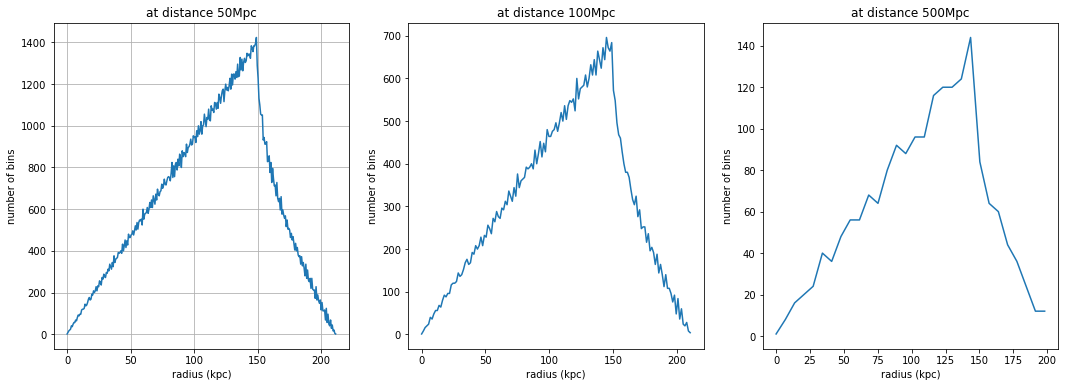

In [23]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18, 6))

center, radi = (data_pretend_50.shape[0]/2,data_pretend_50.shape[1]/2), 55
r_50,tbin_50,nr_50,rad_50 = radial_profile(data_pretend_50, center, debug=True)
ax1.plot(np.arange(len(nr_50))*kpcperpix_50,nr_50)

center, radi = (data_pretend_100.shape[0]/2,data_pretend_100.shape[1]/2), 55
r_100,tbin_100,nr_100,rad_100 = radial_profile(data_pretend_100, center, debug=True)
ax2.plot(np.arange(len(nr_100))*kpcperpix_100,nr_100)

center, radi = (data_pretend_500.shape[0]/2,data_pretend_500.shape[1]/2), 55
r_500,tbin_500,nr_500,rad_500 = radial_profile(data_pretend_500, center, debug=True)
ax3.plot(np.arange(len(nr_500))*kpcperpix_500,nr_500)

ax1.grid()
ax1.set_title('at distance 50Mpc')
ax2.set_title('at distance 100Mpc')
ax3.set_title('at distance 500Mpc')

ax1.set_xlabel('radius (kpc)')
ax2.set_xlabel('radius (kpc)')
ax3.set_xlabel('radius (kpc)')
ax1.set_ylabel('number of bins')
ax2.set_ylabel('number of bins')
ax3.set_ylabel('number of bins')

We use (number of bins) times 3 to approximate the number of pixels (since want more than one pixel wide in the averaging).

[ 9.34746001  3.5172619 ]


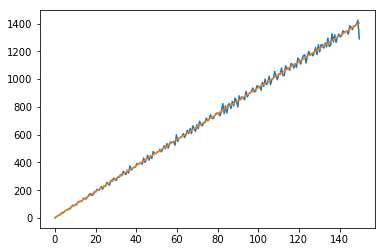

In [58]:
# Define the radius from the azimuthal averaging done above and select out only the bits that didnt run into the end of the image
radius = np.arange(len(nr_50))*kpcperpix_50
numbins= nr_50[radius<150]
radius = radius[radius<150]

print np.polyfit(radius, numbins, 1)

numbins_smooth = 9.347*radius + 3.517

plt.plot(radius,numbins)
plt.plot(radius,numbins_smooth)

Let's take the closest distance (50Mpc)

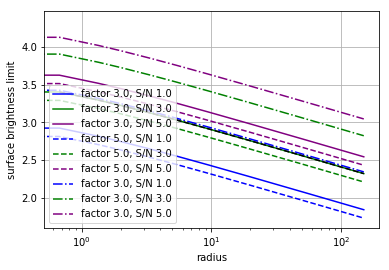

In [92]:
# Define the radius from the azimuthal averaging done above and select out only the bits that didnt run into the end of the image
# Using the fit and smoothed numbin values

def plotSBlim(factor = 3.,sigtonoise=1.,exptime=100. * 60.* 60.* u.second,linestyle='-',color=None):
    numpix = numbins_smooth * factor
    SB3sigmalim = getSB(signaltonoise = sigtonoise * u.photon**(1/2.),numpixel = numpix,time = exptime)
    plt.plot((radius),np.log10(SB3sigmalim.value),linestyle = linestyle,\
             label = 'factor %s, S/N %s'%(factor,sigtonoise),color=color)
    return SB3sigmalim
    
SB1sigmalim = plotSBlim(factor = 3.,sigtonoise=1.,color = 'blue')
SB3sigmalim = plotSBlim(factor = 3.,sigtonoise=3.,color='green')
SB5sigmalim = plotSBlim(factor = 3.,sigtonoise=5.,color='purple')

SB1sigmalim_5 = plotSBlim(factor = 5.,sigtonoise=1.,linestyle='--',color = 'blue')
SB3sigmalim_5 = plotSBlim(factor = 5.,sigtonoise=3.,linestyle='--',color='green')
SB5sigmalim_5 = plotSBlim(factor = 5.,sigtonoise=5.,linestyle='--',color='purple')
    
SB1sigmalim_10hr = plotSBlim(factor = 3.,sigtonoise=1.,color = 'blue',exptime=10. * 60.* 60.* u.second,linestyle='-.')
SB3sigmalim_10hr = plotSBlim(factor = 3.,sigtonoise=3.,color='green',exptime=10. * 60.* 60.* u.second,linestyle='-.')
SB5sigmalim_10hr = plotSBlim(factor = 3.,sigtonoise=5.,color='purple',exptime=10. * 60.* 60.* u.second,linestyle='-.')

plt.grid()
plt.xscale('log')
plt.xlabel('radius')
plt.ylabel('surface brightness limit')
plt.legend()

# Export the numbers so we can use them in the other script
#print np.transpose([radius,SB3sigmalim])

ff = open('SignalToNoise_azimuthalaveraging_limits_sigma3.txt','w') 
ff.write('# radius SB3sigmalim')
for i in range(len(radius)):
    ff.write('%s %s \n'%(radius[i],SB3sigmalim[i].value))
ff.close()

ff = open('SignalToNoise_azimuthalaveraging_limits_sigma1.txt','w') 
ff.write('# radius SB1sigmalim')
for i in range(len(radius)):
    ff.write('%s %s \n'%(radius[i],SB1sigmalim[i].value))
ff.close()


ff = open('SignalToNoise_azimuthalaveraging_limits_sigma1_5.txt','w') 
ff.write('# radius SB1sigmalim')
for i in range(len(radius)):
    ff.write('%s %s \n'%(radius[i],SB1sigmalim_5[i].value))
ff.close()


ff = open('SignalToNoise_azimuthalaveraging_limits_sigma3_5.txt','w') 
ff.write('# radius SB1sigmalim')
for i in range(len(radius)):
    ff.write('%s %s \n'%(radius[i],SB3sigmalim_5[i].value))
ff.close()

ff = open('SignalToNoise_azimuthalaveraging_limits_sigma5.txt','w') 
ff.write('# radius SB5sigmalim')
for i in range(len(radius)):
    ff.write('%s %s \n'%(radius[i],SB5sigmalim[i].value))
ff.close()

ff = open('SignalToNoise_azimuthalaveraging_limits_sigma5_10hr.txt','w') 
ff.write('# radius SB5sigmalim_10hr')
for i in range(len(radius)):
    ff.write('%s %s \n'%(radius[i],SB5sigmalim_10hr[i].value))
ff.close()

# practice reading in the file for the other script

ff = open('SignalToNoise_azimuthalaveraging_limits.txt','r')
readradius = []
readSB = []
for line in ff:
    if line[0]!='#'and len(line)>5:
        tmp = line.split()
        readradius.append(tmp[0])
        readSB.append(tmp[1])
ff.close()
readradius = np.array(readradius,'d')
readSB = np.array(readSB,'d')

#data = np.loadtxt('SignalToNoise_azimuthalaveraging_limits.txt', dtype='f')
#print data[0]

plt.plot(readradius,np.log10(readSB),'k--')

#plt.xscale('log')

Taking another distance, looks good

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 155 but corresponding boolean dimension is 110
  app.launch_new_instance()


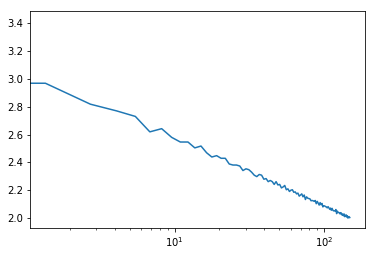

In [37]:
radius = np.arange(len(nr_100))*kpcperpix_100
radius = radius[radius<150]
numpix = nr_100[radius<150] * 3.

SB3sigmalim = getSB(signaltonoise = 1. * u.photon**(1/2.),numpixel = numpix,time = 100. * 60.* 60.* u.second)

plt.plot((radius),np.log10(SB3sigmalim.value))
plt.xscale('log')

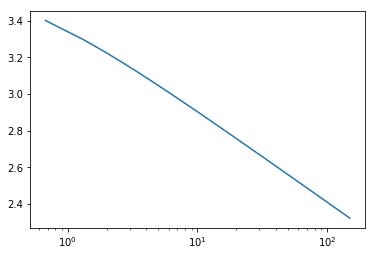

In [71]:
# practice reading in the file for the other script

ff = open('SignalToNoise_azimuthalaveraging_limits.txt','r')
readradius = []
readSB = []
for line in ff:
    if line[0]!='#'and len(line)>5:
        tmp = line.split()
        readradius.append(tmp[0])
        readSB.append(tmp[1])
ff.close()
readradius = np.array(readradius,'d')
readSB = np.array(readSB,'d')

plt.plot(readradius,np.log10(readSB))
plt.xscale('log')